# Volume Rendering with Python and VTK

## Imports

In [15]:
import os
import numpy
import vtk

---

## Helper-functions

We're gonna use this function to embed a still image of a VTK render

In [16]:
from IPython.display import Image
def vtk_show(renderer, width=400, height=300):
    """
    Takes vtkRenderer instance and returns an IPython Image with the rendering.
    """
    renderWindow = vtk.vtkRenderWindow()
    renderWindow.SetOffScreenRendering(1)
    renderWindow.AddRenderer(renderer)
    renderWindow.SetSize(width, height)
    renderWindow.Render()
     
    windowToImageFilter = vtk.vtkWindowToImageFilter()
    windowToImageFilter.SetInput(renderWindow)
    windowToImageFilter.Update()
     
    writer = vtk.vtkPNGWriter()
    writer.SetWriteToMemory(1)
    writer.SetInputConnection(windowToImageFilter.GetOutputPort())
    writer.Write()
    data = str(buffer(writer.GetResult()))
    
    return Image(data)

In [17]:
def createDummyRenderer():
    renderer = vtk.vtkRenderer()
    renderer.SetBackground(1.0, 1.0, 1.0)

    camera = renderer.MakeCamera()
    camera.SetPosition(-256, -256, 512)
    camera.SetFocalPoint(0.0, 0.0, 255.0)
    camera.SetViewAngle(30.0)
    camera.SetViewUp(0.46, -0.80, -0.38)
    renderer.SetActiveCamera(camera)
    
    return renderer

In [18]:
l2n = lambda l: numpy.array(l)
n2l = lambda n: list(n)

---

## Options

In [19]:
# Path to the .mha file
filenameSegmentation = "./nac_brain_atlas/brain_segmentation.mha"

# Path to colorfile.txt 
filenameColorfile = "./nac_brain_atlas/colorfile.txt"

# Opacity of the different volumes (between 0.0 and 1.0)
volOpacityDef = 0.25

## Image-Data Input

In [39]:
reader = vtk.vtkMetaImageReader()
reader.SetFileName(filenameSegmentation)

castFilter = vtk.vtkImageCast()
castFilter.SetInputConnection(reader.GetOutputPort())
castFilter.SetOutputScalarTypeToUnsignedShort()
castFilter.Update()

imdataBrainSeg = castFilter.GetOutputPort()
idbs = castFilter.GetOutput()

In [40]:
imdataBrainSeg.

(vtkCommonExecutionModelPython.vtkAlgorithmOutput)0x7fb2d4baa600

---

## Prep-work

### Transfer functions

Read colorfile into a dictionary

In [21]:
import csv
fid = open(filenameColorfile, "r")
reader = csv.reader(fid)

dictRGB = {}
for line in reader:
    dictRGB[int(line[0])] = [float(line[2])/255.0,
                             float(line[3])/255.0,
                             float(line[4])/255.0]
fid.close()

Define color transfer function

In [22]:
funcColor = vtk.vtkColorTransferFunction()

for idx in dictRGB.keys():
    funcColor.AddRGBPoint(idx, 
                          dictRGB[idx][0],
                          dictRGB[idx][1],
                          dictRGB[idx][2])

Define scalar opacity transfer function

In [23]:
funcOpacityScalar = vtk.vtkPiecewiseFunction()

for idx in dictRGB.keys():
    funcOpacityScalar.AddPoint(idx, volOpacityDef if idx!=0 else 0.0)

Define gradient opacity transfer function

In [24]:
funcOpacityGradient = vtk.vtkPiecewiseFunction()

funcOpacityGradient.AddPoint(1,   0.0)
funcOpacityGradient.AddPoint(5,   0.1)
funcOpacityGradient.AddPoint(100,   1.0)

2

### Volume Properties

In [25]:
propVolume = vtk.vtkVolumeProperty()
propVolume.ShadeOff()
propVolume.SetColor(funcColor)
propVolume.SetScalarOpacity(funcOpacityScalar)
propVolume.SetGradientOpacity(funcOpacityGradient)
propVolume.SetInterpolationTypeToLinear()

---

## Volume Rendering

### vtkVolumeRayCastMapper

In [36]:
volumeMapper = vtk.vtkFixedPointVolumeRayCastMapper()
volumeMapper.SetInputConnection(imdataBrainSeg)

volume = vtk.vtkVolume()
volume.SetMapper(volumeMapper)
volume.SetProperty(propVolume)

renderer = vtk.vtkRenderer()
renderWin = vtk.vtkRenderWindow()
renderWin.AddRenderer(renderer)
renderInteractor = vtk.vtkRenderWindowInteractor()
renderInteractor.SetRenderWindow(renderWin)

colors = vtk.vtkNamedColors()

# We add the volume to the renderer …
renderer.AddVolume(volume)
renderer.SetBackground(colors.GetColor3d("black"))

# … and set window size.
renderWin.SetSize(400, 400)

# A simple function to be called when the user decides to quit the application.
def exitCheck(obj, event):
    if obj.GetEventPending() != 0:
        obj.SetAbortRender(1)

# Tell the application to use the function as an exit check.
renderWin.AddObserver("AbortCheckEvent", exitCheck)
#Init
renderInteractor.Initialize()
# Because nothing will be rendered without any input, we order the first render manually
# before control is handed over to the main-loop.
renderWin.Render()
renderInteractor.Start()

#### Clipping Plane

In [35]:
_origin = l2n(imdataBrainSeg.GetOrigin())
_spacing = l2n(imdataBrainSeg.GetSpacing())
_dims = l2n(imdataBrainSeg.GetDimensions())
_center = n2l(_origin+_spacing*(_dims/2.0))

planeClip = vtk.vtkPlane()
planeClip.SetOrigin(_center)
planeClip.SetNormal(0.0, 0.0, -1.0)

AttributeError: 'vtkCommonExecutionModelPython.vtkAlgorithmOutput' object has no attribute 'GetOrigin'

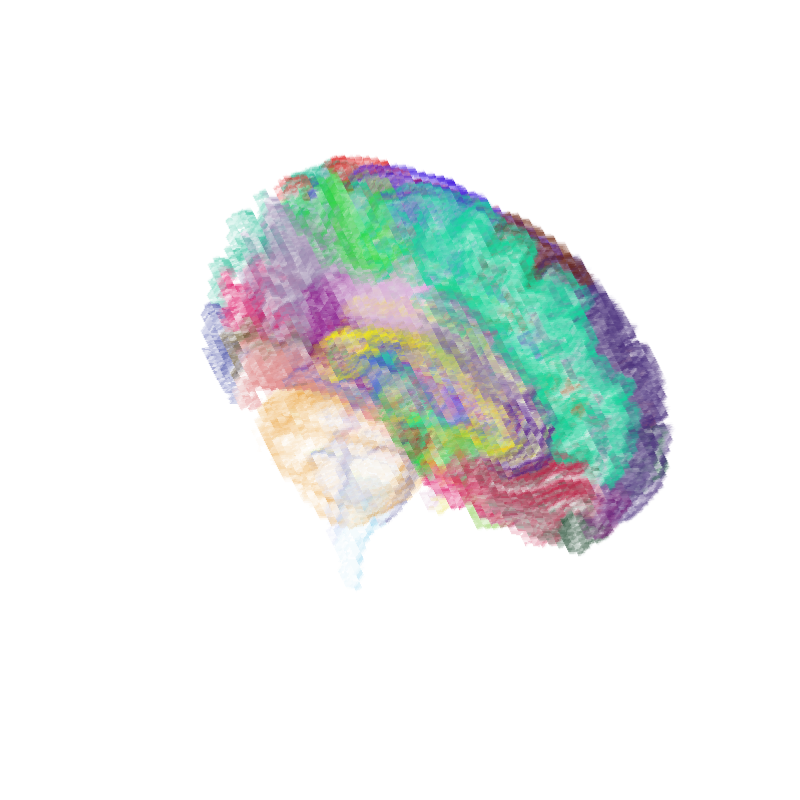

In [14]:
funcRayCast = vtk.vtkVolumeRayCastCompositeFunction()
funcRayCast.SetCompositeMethodToClassifyFirst()

mapperVolume = vtk.vtkVolumeRayCastMapper()
mapperVolume.SetVolumeRayCastFunction(funcRayCast)
mapperVolume.SetInput(imdataBrainSeg)
mapperVolume.AddClippingPlane(planeClip)

actorVolume = vtk.vtkVolume()
actorVolume.SetMapper(mapperVolume)
actorVolume.SetProperty(propVolume)

renderer = createDummyRenderer()
renderer.AddActor(actorVolume)

vtk_show(renderer, 800, 800)

---

### vtkVolumeTextureMapper2D

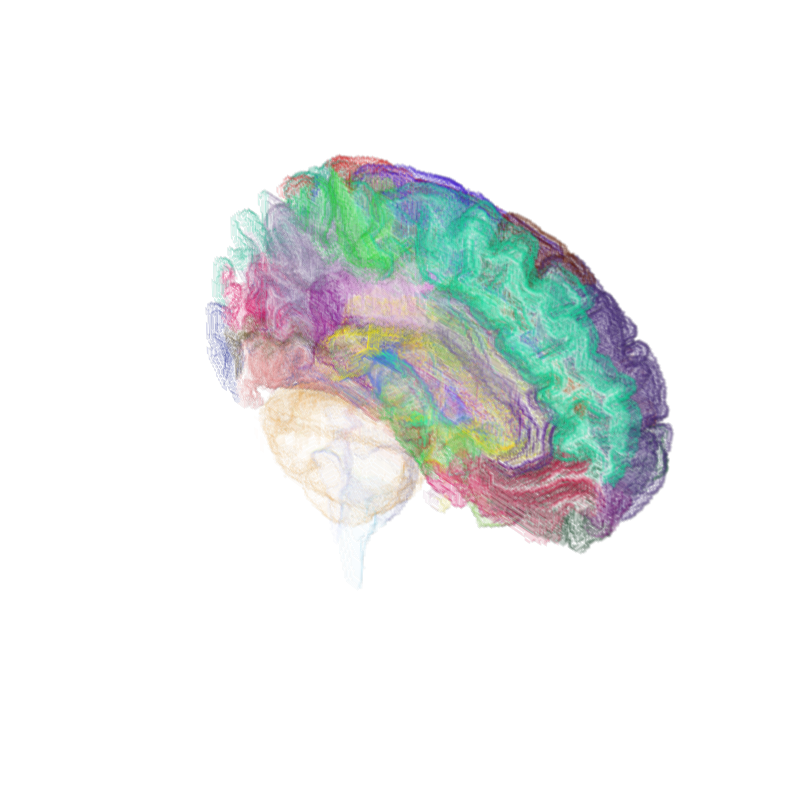

In [15]:
mapperVolume = vtk.vtkVolumeTextureMapper2D()
mapperVolume.SetInput(imdataBrainSeg)
mapperVolume.AddClippingPlane(planeClip)

actorVolume = vtk.vtkVolume()
actorVolume.SetMapper(mapperVolume)
actorVolume.SetProperty(propVolume)

renderer = createDummyRenderer()
renderer.AddActor(actorVolume)

vtk_show(renderer, 800, 800)

---

---

### vtkGPUVolumeRayCastMapper

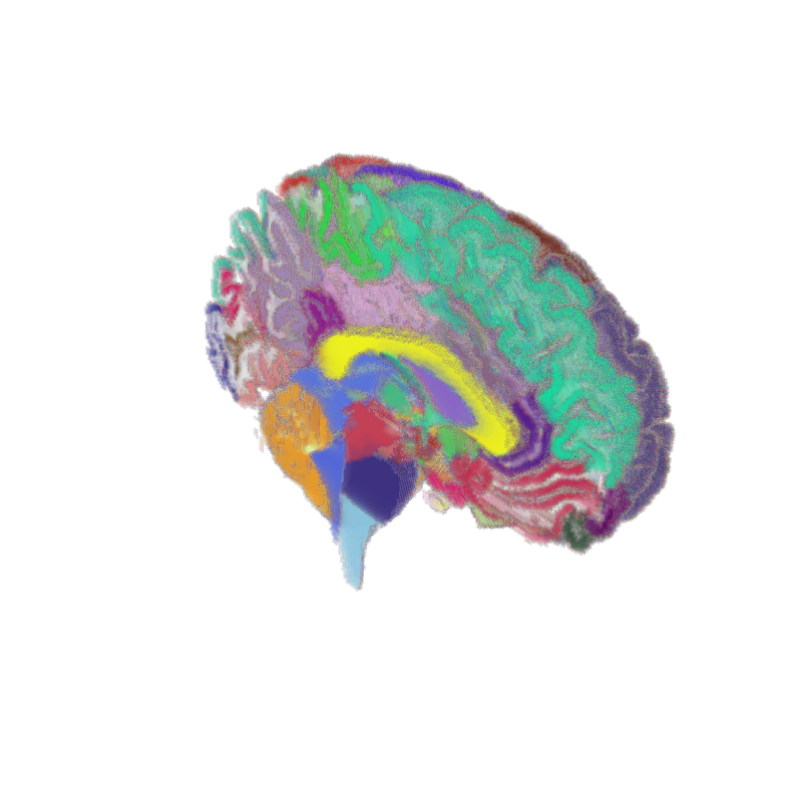

In [16]:
mapperVolume = vtk.vtkGPUVolumeRayCastMapper()
mapperVolume.SetInput(imdataBrainSeg)
mapperVolume.AddClippingPlane(planeClip)

actorVolume = vtk.vtkVolume()
actorVolume.SetMapper(mapperVolume)
actorVolume.SetProperty(propVolume)

renderer = createDummyRenderer()
renderer.AddActor(actorVolume)

vtk_show(renderer, 800, 800)

### vtkFixedPointVolumeRayCastMapper

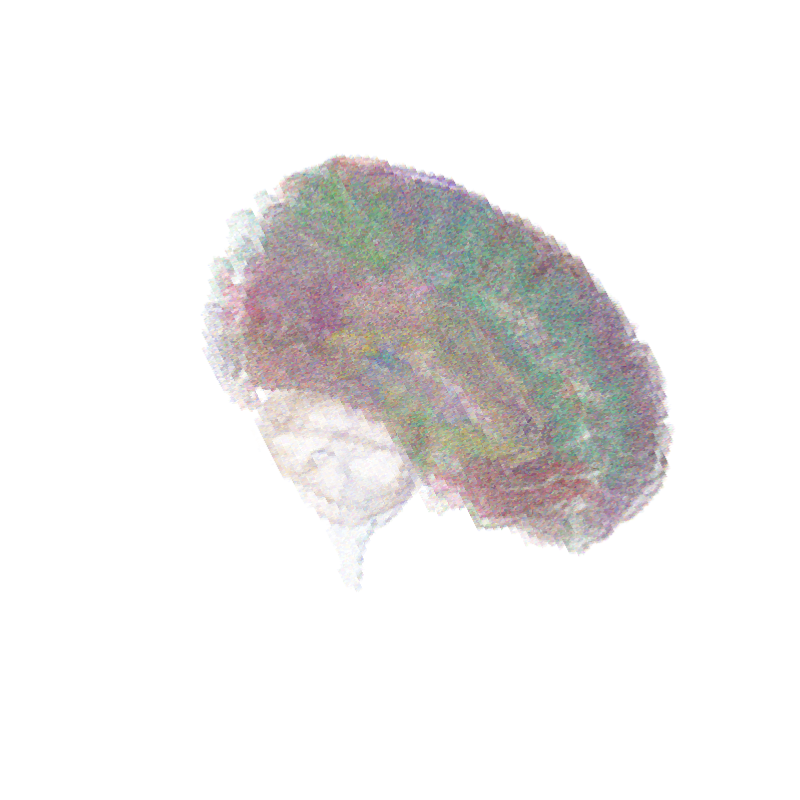

In [17]:
mapperVolume = vtk.vtkFixedPointVolumeRayCastMapper()
mapperVolume.SetInput(imdataBrainSeg)
mapperVolume.AddClippingPlane(planeClip)

actorVolume = vtk.vtkVolume()
actorVolume.SetMapper(mapperVolume)
actorVolume.SetProperty(propVolume)

renderer = createDummyRenderer()
renderer.AddActor(actorVolume)

vtk_show(renderer, 800, 800)

### vtkVolumeTextureMapper3D

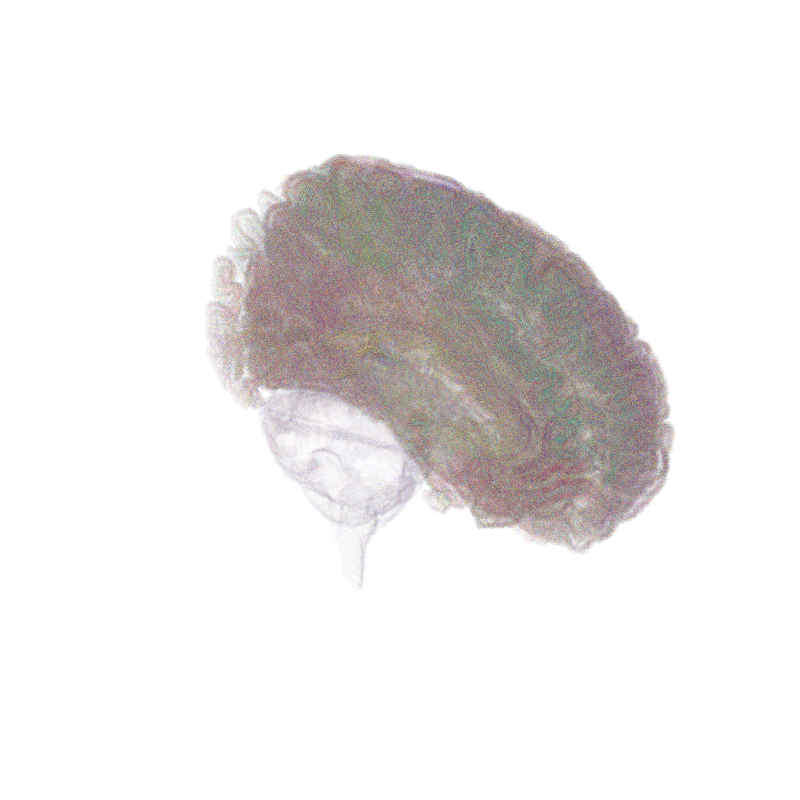

In [18]:
mapperVolume = vtk.vtkVolumeTextureMapper3D()
mapperVolume.SetInput(imdataBrainSeg)
mapperVolume.AddClippingPlane(planeClip)

actorVolume = vtk.vtkVolume()
actorVolume.SetMapper(mapperVolume)
actorVolume.SetProperty(propVolume)

renderer = createDummyRenderer()
renderer.AddActor(actorVolume)

vtk_show(renderer, 800, 800)